POT Simplified Mode tutorial

In [47]:
import os
import torch
import json
from pathlib import Path
import random
from compression.api import DataLoader
from addict import Dict

# Set the data and model directories
MODEL_DIR = 'model'
CALIB_DIR = 'calib'
CIFAR_DIR = 'cifar'
CALIB_SET_SIZE = 300

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CALIB_DIR, exist_ok=True)

Now we need to create the calibration dataset from the preprocessed ImageNet images

In [48]:
from torchvision import transforms as T
from torchvision.datasets import CIFAR10

transform = T.Compose([T.ToTensor()])
dataset = CIFAR10(root=CIFAR_DIR, train=False, transform=transform, download=True)
class CifarDataLoader(DataLoader):

    def __init__(self, config, dataset, shuffle=True):
        """
        Initialize config and dataset.
        :param config: created config with DATA_DIR path.
        """
        if not isinstance(config, Dict):
            config = Dict(config)
        super().__init__(config)
        self.data = self.load_data(dataset, shuffle)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        Return one sample of index, label and picture.
        :param index: index of the taken sample.
        """
        if index >= len(self):
            raise IndexError

        return (self.data[index][0], self.data[index][2]), self.data[index][1].squeeze(0)

    def load_data(self, dataset, shuffle):
        """
        Load dataset in needed format. 
        :param dataset:  downloaded dataset.
        """
        data = [(idx, sample[0], sample[1]) for idx, sample in enumerate(dataset)]
        if shuffle:
            random.shuffle(data)
        return data

dataset_config = Dict({
    'data_source': CIFAR_DIR
})
data_loader = CifarDataLoader(dataset_config, dataset, shuffle=False)

Files already downloaded and verified


In [49]:
pil_converter = T.ToPILImage(mode="RGB")
counter = 0
for info, im in data_loader:
    idx = info[0]
    if counter >= CALIB_SET_SIZE:
        break
    label = info[1]
    pil_converter(im).save(Path(CALIB_DIR) / f'{label}_{idx}.png')
    counter += 1

In the first step we need to export the model, which we need to optimize, into the ONNX format:

In [50]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg19_bn", pretrained=True)
dummy_input = torch.randn(1, 3, 32, 32)

onnx_model_path = Path(MODEL_DIR) / 'vgg19.onnx'
ir_model_xml = onnx_model_path.with_suffix('.xml')
ir_model_bin = onnx_model_path.with_suffix('.bin')

torch.onnx.export(model, dummy_input, onnx_model_path)

Using cache found in /home/tagir/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Now we convert this model into the OpenVINO IR using the Model Optimizer

In [51]:
!mo --framework=onnx --data_type=FP16 --input_shape=[1,3,32,32] -m $onnx_model_path  --output_dir $MODEL_DIR

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/tagir/work/openvino_notebooks/notebooks/114-simplified-mode/model/vgg19.onnx
	- Path for generated IR: 	/home/tagir/work/openvino_notebooks/notebooks/114-simplified-mode/model
	- IR output name: 	vgg19
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3,32,32]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
	- Use legacy API for model processing: 	False
	- Use the transformations config file: 	None
	- OpenVINO runtime found in: 	/home/tag

In this step we need to write the optimization config and export it to .json file

In [52]:
config = dict({
    "model": {
        "model_name": "vgg19",
        "model": str(ir_model_xml),
        "weights": str(ir_model_bin)
    },

    "engine": {
        "type": "simplified",
        "data_source": CALIB_DIR
    },

    "compression": {
        "target_device": "ANY",
        "algorithms": [
            {
                "name": "DefaultQuantization",
                "params": {
                    "preset": "performance",
                    "stat_subset_size": 300
                }
            }
        ]
    }
})

with open("config.json", "w") as outfile:
    json.dump(config, outfile)

Now we can optimize the model using this configuration file by calling the following command

In [53]:
!pot --output-dir compressed -c config.json

INFO:openvino.tools.pot.app.run:Output log dir: compressed/vgg19_DefaultQuantization/2022-02-16_14-38-44
INFO:openvino.tools.pot.app.run:Creating pipeline:
 Algorithm: DefaultQuantization
 Parameters:
	preset                     : performance
	stat_subset_size           : 300
	target_device              : ANY
	model_type                 : None
	dump_intermediate_model    : False
	inplace_statistics         : True
	exec_log_dir               : compressed/vgg19_DefaultQuantization/2022-02-16_14-38-44
INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.1.0-6582-50dffb80bb9
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.1.0-6386-d5b74b0c6b3
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.1.0-6386-d5b74b0c6b3
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing stati

Here you need to set the new optimized model path.

It looks like "compressed/{MODEL_NAME}_DefaultQuantization/{DateTime}/optimized"

In [54]:
optimized_model_path = Path('compressed/vgg19_DefaultQuantization/2022-02-16_14-38-44/optimized')
optimized_model_xml = optimized_model_path / 'vgg19.xml'
optimized_model_bin = optimized_model_path / 'vgg19.bin'

In [55]:
# Inference FP32 model (IR)
!benchmark_app -m $ir_model_xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] -hint default value is determined as 'THROUGHPUT' automatically for CPU deviceFor more detailed information look at README.
[ INFO ] OpenVINO:
         API version............. 2022.1.0-6582-50dffb80bb9
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.1
         Build................... 2022.1.0-6582-50dffb80bb9

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] Reading network files
[ I

In [56]:
# Inference INT8 model (IR)
!benchmark_app -m $optimized_model_xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] -hint default value is determined as 'THROUGHPUT' automatically for CPU deviceFor more detailed information look at README.
[ INFO ] OpenVINO:
         API version............. 2022.1.0-6582-50dffb80bb9
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.1
         Build................... 2022.1.0-6582-50dffb80bb9

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] Reading network files
[ I

In [57]:
from openvino.inference_engine import IECore

ie = IECore()

# read and load quantized model
quantized_net = ie.read_network(
    model=optimized_model_xml, weights=optimized_model_bin
)
quantized_net = ie.load_network(network=quantized_net, device_name="CPU")

In [58]:
# define all possible labels from CIFAR10
labels_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
all_pictures = []
all_labels = []

# get all pictures and their labels 
for i, batch in enumerate(data_loader):
    all_pictures.append(batch[1])
    all_labels.append(batch[0][1])

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pictures(indexes: list, all_pictures=all_pictures, all_labels=all_labels):
    """Plot 4 pictures.
    :param indexes: a list of indexes of pictures to be displayed.
    :param all_batches: batches with pictures.
    """
    num_pics = len(indexes)
    f, axarr = plt.subplots(1, num_pics)
    for idx, im_idx in enumerate(indexes):
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        pic = np.rollaxis(all_pictures[im_idx].squeeze().numpy(), 0, 3)
        axarr[idx].imshow(pic)
        axarr[idx].set_title(labels_names[all_labels[im_idx]])

In [60]:
def infer_on_pictures(net, indexes: list, all_pictures=all_pictures):
    """ Inference model on a few pictures.
    :param net: model on which do inference
    :param indexes: list of indexes 
    """
    predicted_labels = []
    for idx in indexes:
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        result = list(net.infer(inputs={'input.1': all_pictures[idx]}).values())
        result = labels_names[np.argmax(result[0])]
        predicted_labels.append(result)
    return predicted_labels

Labels for picture from quantized model : ['cat', 'bird', 'bird'].


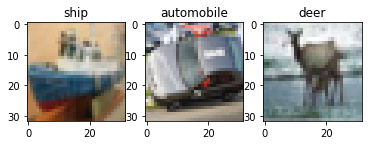

In [61]:
indexes_to_infer = [0, 1, 2]  # to plot specify 4 indexes

plot_pictures(indexes_to_infer)

results_quanized = infer_on_pictures(quantized_net, indexes_to_infer)

print(f"Labels for picture from quantized model : {results_quanized}.")